# Titanic ANN Model

In this notebook we will look at an artifical neural net model of classification and try tune its parameters in order to train the best model for the problem set. 

### Data Preprocessing

In [1]:
# Importing basic libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random

# Importing plotting libraries
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

# Importing sklearn support libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

# Setting parameters
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# Functions used to create and return a confusion matrix and an accuracy score for each model
def confusion_matrix(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    y_pred = (y_pred > 0.6)
    return metrics.confusion_matrix(y_test, y_pred)


def accuracy_score(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    y_pred = (y_pred > 0.6)
    return metrics.accuracy_score(y_test, y_pred)

In [3]:
# Read the data from the csv and print the first 5 entries of the training data
data = pd.read_csv("data/train.csv", index_col = "PassengerId")
comp_data = pd.read_csv("data/test.csv", index_col = "PassengerId")
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Drop Columns not to be used
data = data.drop(["Name", "Ticket", "Cabin"], axis=1)
comp_data = comp_data.drop(["Name", "Ticket", "Cabin"], axis=1)

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [5]:
# Replacing nans with mean age for missing ages
# data["Age"] = data["Age"].fillna(data["Age"].mean())

# Replacing the missing age with the median age based on the passengers class 
data["Age"] = data.groupby("Pclass")["Age"].apply(lambda x:  x.fillna(round(x.median())))
comp_data["Age"] = comp_data.groupby("Pclass")["Age"].apply(lambda x:  x.fillna(round(x.median())))

# Replacing the missing port with the port of Southhampton as that is where the majority of passengers boarded
data["Embarked"] = data["Embarked"].fillna("S")
comp_data["Embarked"] = comp_data["Embarked"].fillna("S")

# Replacing the missing fare with the mean of classes fare
comp_data["Fare"] = comp_data.groupby("Pclass")["Fare"].apply(lambda x:  x.fillna(round(x.mean())))

# Make sure there are no missing entries
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [6]:
# Combining the SibSp and Parch values into one value, number of family members on board 
data["Family"] = data["SibSp"] + data["Parch"]
comp_data["Family"] = comp_data["SibSp"] + comp_data["Parch"]

# Drop the SibSp and Parch columns 
data = data.drop(["SibSp", "Parch"], axis=1)
comp_data = comp_data.drop(["SibSp", "Parch"], axis=1)
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
PassengerId,,,,,,,
1,0,3,male,22.0,7.2500,S,1
2,1,1,female,38.0,71.2833,C,1
3,1,3,female,26.0,7.9250,S,0
4,1,1,female,35.0,53.1000,S,1
5,0,3,male,35.0,8.0500,S,0


In [7]:
# Encode Pclass, Sex, and Embarked into dummy variables
data = pd.concat([data, pd.get_dummies(data["Pclass"], prefix='Pclass')],axis=1)
data = pd.concat([data, pd.get_dummies(data["Sex"], prefix='Sex')],axis=1)
data = pd.concat([data, pd.get_dummies(data["Embarked"], prefix='Embarked')],axis=1)

comp_data = pd.concat([comp_data, pd.get_dummies(comp_data["Pclass"], prefix='Pclass')],axis=1)
comp_data = pd.concat([comp_data, pd.get_dummies(comp_data["Sex"], prefix='Sex')],axis=1)
comp_data = pd.concat([comp_data, pd.get_dummies(comp_data["Embarked"], prefix='Embarked')],axis=1)

# Drop the encoded columns
data = data.drop(["Pclass", "Sex", "Embarked"], axis=1)
comp_data = comp_data.drop(["Pclass", "Sex", "Embarked"], axis=1)

data.head()

,Survived,Age,Fare,Family,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
1,0,22.0,7.2500,1,0,0,1,0,1,0,0,1
2,1,38.0,71.2833,1,1,0,0,1,0,1,0,0
3,1,26.0,7.9250,0,0,0,1,1,0,0,0,1
4,1,35.0,53.1000,1,1,0,0,1,0,0,0,1
5,0,35.0,8.0500,0,0,0,1,0,1,0,0,1


In [8]:
# Seperate the data into training data and test data
y = data["Survived"]
X = data.drop(["Survived"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
# Apply a standard scalar across the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
# Calculate the number of hidden neurons based on rule of thumb
neurons = int((len(X_train[0]))*(2/3))
print("Neurons: %s" % neurons)

repeats = 30
results = pd.DataFrame()

Neurons: 7


### Epochs 

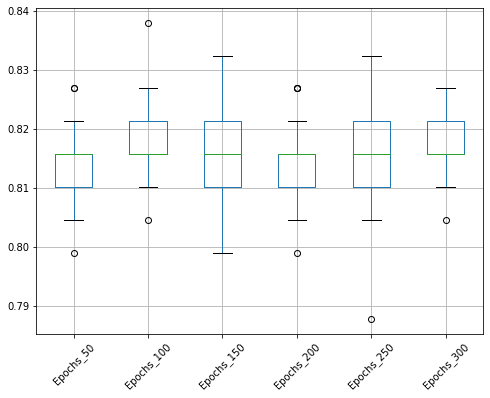

In [11]:
epochs = [50, 100, 150, 200, 250, 300]
for epoch in epochs:
    ac_scores = []
    for i in range(repeats):
        ann = tf.keras.models.Sequential()

        ann.add(tf.keras.layers.Dense(units=neurons, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=neurons, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

        ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae','mse','mape'])

        history = ann.fit(X_train, y_train, epochs=epoch, verbose=0)

        ac = accuracy_score(ann, X_test, y_test)
        ac_scores.append(ac)

    results["Epochs_"+str(epoch)] = ac_scores

results.boxplot(rot=45)

### Hidden layers

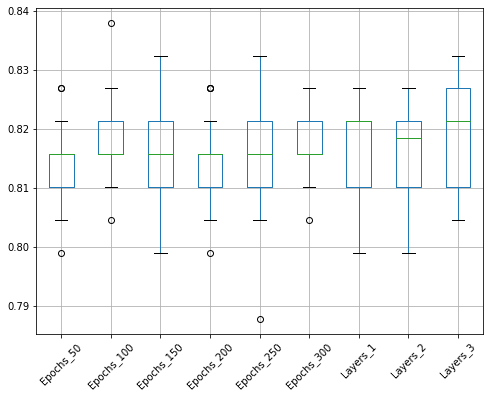

In [12]:
layers = [1,2,3]
for layer in layers:
    ac_scores = []
    for i in range(repeats):
        ann = tf.keras.models.Sequential()
        for j in range(layer):
            ann.add(tf.keras.layers.Dense(units=neurons, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

        ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae','mse','mape'])

        history = ann.fit(X_train, y_train, epochs=200, verbose=0)

        ac = accuracy_score(ann, X_test, y_test)
        ac_scores.append(ac)

    results["Layers_"+str(layer)] = ac_scores

results.boxplot(rot=45)

### Neurons

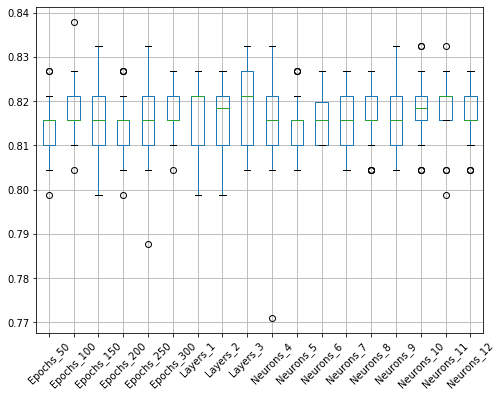

In [13]:
neurons = [4, 5, 6, 7, 8, 9, 10, 11, 12]
for neuron in neurons:
    ac_scores = []
    for i in range(repeats):
        ann = tf.keras.models.Sequential()

        ann.add(tf.keras.layers.Dense(units=neuron, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=neuron, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

        ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae','mse','mape'])

        history = ann.fit(X_train, y_train, epochs=200, verbose=0)

        ac = accuracy_score(ann, X_test, y_test)
        ac_scores.append(ac)

    results["Neurons_"+str(neuron)] = ac_scores

results.boxplot(rot=45)

There is some variability in the data but from all the testing above it appears that the best combination of parameters that give the highest accuracy score are: 
 - 200 epochs
 - 2 hidden layers
 - 8 neurons 

In [16]:
ann = tf.keras.models.Sequential()

ann.add(tf.keras.layers.Dense(units=8, activation='relu'))
ann.add(tf.keras.layers.Dense(units=8, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae','mse','mape'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, mode='min')

history = ann.fit(X_train, y_train, epochs=200, callbacks=[early_stopping], verbose=0)

cm = confusion_matrix(ann, X_test, y_test)
ac = accuracy_score(ann, X_test, y_test)
print("Confusion Matrix:\n %s" % cm)
print("Accuracy Score: %.3f" % (ac))

Confusion Matrix:
 [[103   7]
 [ 26  43]]
Accuracy Score: 0.816


In [15]:
comp_X = sc.transform(comp_data)

comp_y = {}
for index, row in comp_data.iterrows():
    val = ann.predict(sc.transform([row]))[0][0]
    if val > 0.6:
        comp_y[index] = 1
    else:
        comp_y[index] = 0

import csv
with open('results/result_ann.csv','w') as f:
    w = csv.writer(f)
    w.writerows(comp_y.items())